In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import proplot as pplt
from scipy.fftpack import * 
import metpy

## 2D DCT get 1D spectrum
按照Denis 2002的方法进行2D dct的谱合并，制作1D谱分析

## 2021.07.26 renew

修正了DCTN的方法，用正交的方法，检查平均值和0，0位置的谱；具体见denis 2002对于谱方差的计算，以及修改后绘制的振幅（对方差开方）

添加ERA5I的动能谱

## 2021.08.13 renew

添加简单的计算经纬度网格上的测地线距离的方法

## 2021.10.18 renew

在同目录的 interp_rcmgrid.ipynb 的处理之后，得到新的投影网格下的模式结果，进行谱分析



## 数据读入

2021.08.23

修改为在高度上进行积分的动能Ke

In [2]:
in_path = {}
case_number = "case3"
filename = "ke_all_8.5-11.5_km_vi_LambertConformal_" + case_number + ".nc"
in_path['vr'] = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/ke_daily_vi_proj/" + filename # VR
in_path['rcm'] = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/ke_daily_vi_proj/" + filename # RCM
in_path['era5i'] = "/raid52/yycheng/MPAS/REFERENCE/ERA5I_NC/ERA5I_NC_daily/ke_daily_vi_proj/" + filename # ERA5I

ke_sum = {}
for imod in ['vr', 'rcm', 'era5i']:
    ke_sum[imod] = xr.open_dataset(in_path[imod])['ke']

In [3]:
# 选取数据范围
sel_dict = {}
month_sel = [6,7,8]
month_sel_vr  = ke_sum['vr'].Time.dt.month.isin(month_sel)
month_sel_rcm = ke_sum['rcm'].Time.dt.month.isin(month_sel)
month_sel_era5i = ke_sum['era5i'].Time.dt.month.isin(month_sel)

var_sel = {}
sel_dict['Time'] = month_sel_vr
var_sel['vr']  = ke_sum['vr'].loc[sel_dict]
sel_dict['Time'] = month_sel_rcm
var_sel['rcm'] = ke_sum['rcm'].loc[sel_dict]
sel_dict['Time'] = month_sel_era5i
var_sel['era5i'] = ke_sum['era5i'].loc[sel_dict]

## DCTN

In [4]:
# 2D fft
# ke_vi_sum # Time x lat x lon : 3080 x 160 x 280
dctn_3d = {}
dctn_3d['vr'] = dctn(var_sel['vr'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['rcm'] = dctn(var_sel['rcm'].values, type = 2, axes = [1,2], norm = 'ortho')
dctn_3d['era5i'] = dctn(var_sel['era5i'].values, type = 2, axes = [1,2], norm = 'ortho')

# 添加维度参数
ntime = dctn_3d['vr'].shape[0]
nlat  = dctn_3d['vr'].shape[1]
nlon  = dctn_3d['vr'].shape[2]

## DCTN CHECK

检查（0,0）位置的系数和区域平均场差异：做差结果: 5.684341886080802e-14


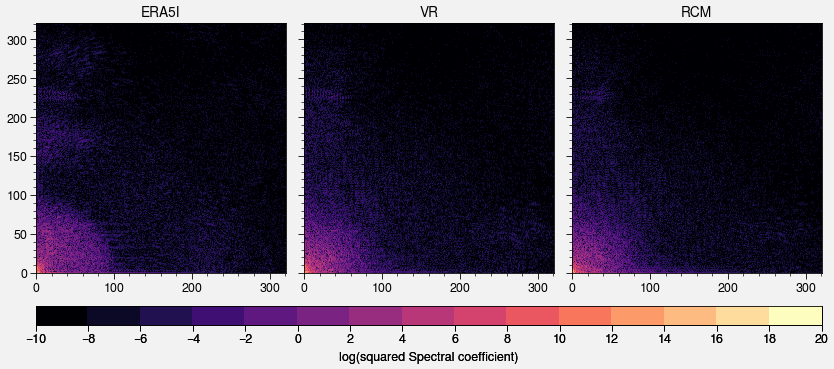

In [5]:
# 平均对应谱的0，0位置的系数检查
# domain_avg 应该和 spectrum_coef 保持一致，为此调整了 DCT 的 norm = 'ortho' 参数，让这个条件满足
domain_avg = var_sel['vr'][0,:,:].values.mean()
spectrum_coef = dctn_3d['vr'][0, 0, 0] / np.sqrt(nlat) / np.sqrt(nlon)
# domain_avg # 252.37
print("检查（0,0）位置的系数和区域平均场差异：做差结果: " + str(spectrum_coef  - domain_avg))

## 使用proplot做简单方差谱的绘制检查
import proplot as pplt
import numpy as np

# 计算方差谱的对数(2D)
variance_era5i = np.log(np.abs(dctn_3d['era5i'][:,:].mean(axis=0)**2))
variance_vr    = np.log(np.abs(dctn_3d['vr'][:,:].mean(axis=0)**2))
variance_rcm    = np.log(np.abs(dctn_3d['rcm'][:,:].mean(axis=0)**2))

# 用proplot仔细画一下
# Figure
fig, axs = pplt.subplots(ncols=3, span=False)
axs.format(
    xlabel='', ylabel='', grid=True,
    suptitle=''
)

# Plot with colormaps and normalizers
cmap = 'magma'
levels =  pplt.arange(-10, 20, 2)
axs[0].pcolormesh(variance_era5i, cmap=cmap, levels = levels)
axs[1].pcolormesh(variance_vr, cmap=cmap, levels = levels)
pcolormesh = axs[2].pcolormesh(variance_rcm, cmap=cmap, levels = levels)
# axs[1].pcolormesh(np.abs(dctn_3d['era5i'][:,:].mean(axis=0)**2), norm='log', cmap=cmap, colorbar='b')

axs[0].format(title='ERA5I')
axs[1].format(title='VR')
axs[2].format(title='RCM')

axs.format(
# xlocator='log', xminorlocator='logminor',
)
fig.colorbar(pcolormesh, loc='b', label = "log(squared Spectral coefficient)")
# domaininfo_str = str(lat_s) + "~" + str(lat_e) + "N_" + str(lon_s) + "~" + str(lon_e) + "E"
# axs[0].format(suptitle = "domain size: " + domaininfo_str)
# plt.savefig('./output_pic/ke_variance_'+domaininfo_str+'.png', dpi=300, facecolor= "white")

## 从2D谱方位角求和获得1D谱

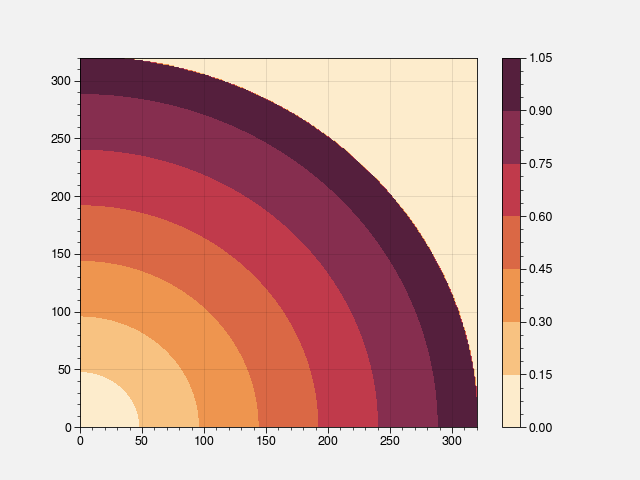

In [6]:
# 仿照denis2002进行2d alpha的预估
# nlat = 160 (miner)
# nlon = 280
Y, X     = np.ogrid[0:nlat, 0:nlon]
r        = np.hypot(X, Y).astype(np.int)
# 2D normalize wavenumber
alpha_2d =  np.empty(shape=r.shape)
for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        alpha_2d[ilat, ilon] = np.sqrt( ilon**2/nlon**2 + ilat**2/nlat**2 )

alpha_1d = np.zeros(shape = int(np.min([nlat,nlon])))
for i in range(0, np.min([nlat, nlon]) ):
    alpha_1d[i] = i / np.min([nlat, nlon])
# 用于确定bins的1D谱
# alpha_1d = np.arange(1,nlat+1, 1) / nlat
# 去除掉alpha_2d中大于1的部分
alpha_2d = np.where(alpha_2d<=1, alpha_2d, 0)
plt.contourf(alpha_2d)
plt.colorbar()

- 旧算法 先计算平均谱再计算1D谱

In [7]:
N = np.min([nlat, nlon])

variance_1d = {}
variance_1d['vr'] =  np.zeros(shape=[nlat])
variance_1d['rcm'] =  np.zeros(shape=[nlat])
variance_1d['era5i'] =  np.zeros(shape=[nlat])

# 按照alpha进行bins，合并2d谱为1d谱，预先进行谱的时间平均

variance_2d = {} # 时间平均???如何平均，平均系数还是平均方差 是一个时次itime 的variance
#  先进行系数的平均，在计算variance
variance_2d['vr'] = (dctn_3d['vr']).mean(axis=0)**2 /nlat /nlon
variance_2d['rcm'] = (dctn_3d['rcm']).mean(axis=0)**2 /nlat /nlon
variance_2d['era5i'] = (dctn_3d['era5i']).mean(axis=0)**2 /nlat /nlon
# 先计算variance，再计算系数的平均
# variance_2d['vr'] = (dctn_3d['vr']**2/nlat /nlon).mean(axis=0) 
# variance_2d['rcm'] = (dctn_3d['rcm']**2/nlat /nlon).mean(axis=0) 
# variance_2d['era5i'] = (dctn_3d['era5i']**2/nlat /nlon).mean(axis=0) 


for i in range(0, np.min([nlat,nlon]) - 1):
    sel_index  = (alpha_2d >= alpha_1d[i]) & (alpha_2d < alpha_1d[i + 1])
    # mean or sum???
    # variance_1d['vr'][i] = variance_2d['vr'][sel_index].mean()
    # variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].mean()
    # 方位角积分
    variance_1d['vr'][i] = variance_2d['vr'][sel_index].sum()
    variance_1d['rcm'][i] = variance_2d['rcm'][sel_index].sum()
    variance_1d['era5i'][i] = variance_2d['era5i'][sel_index].sum()


# 进行三点平滑
# variance_1d['vr']
variance_1d_filter = {}
variance_1d_filter['vr'] = np.empty(N//2)
variance_1d_filter['rcm'] = np.empty(N//2)
variance_1d_filter['era5i'] = np.empty(N//2)
for i in range(0, N//2):
    variance_1d_filter['vr'][i] = variance_1d['vr'][i*2] + 0.5 * variance_1d['vr'][i*2 - 1] + 0.5 * variance_1d['vr'][i*2 + 1]
    variance_1d_filter['rcm'][i] = variance_1d['rcm'][i*2] + 0.5 * variance_1d['rcm'][i*2 - 1] + 0.5 * variance_1d['rcm'][i*2 + 1]
    variance_1d_filter['era5i'][i] = variance_1d['era5i'][i*2] + 0.5 * variance_1d['era5i'][i*2 - 1] + 0.5 * variance_1d['era5i'][i*2 + 1]

## 绘图部分

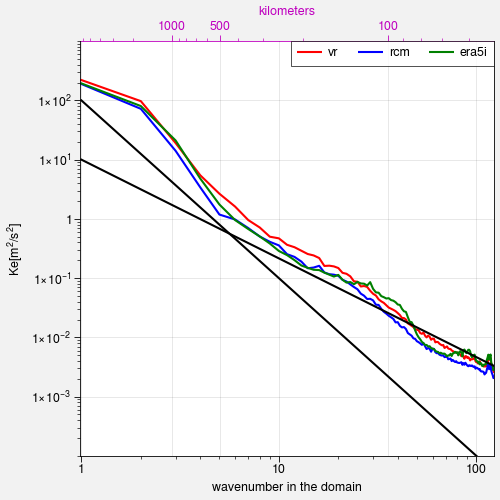

In [8]:
fig, axs = pplt.subplots(ncols = 1,nrows = 1,figsize=(5, 5))
# plt.style.use(['science', 'no-latex']) # 采用 安装的scinence绘图风格，matplotlib风格拓展

# 原始的DCT系数
# axs.plot(xf[:N//2], np.sqrt(variance_smooth['vr']))
xf = np.arange(1,nlon)
xaxis = xf[:N//2]

axs.plot(xaxis, np.sqrt(variance_1d_filter['vr'][:]), label='vr', color='r')
axs.plot(xaxis, np.sqrt(variance_1d_filter['rcm'][:]), label='rcm', color = 'b')
axs.plot(xaxis, np.sqrt(variance_1d_filter['era5i'][:]), label='era5i', color = 'g')
# add reference line 
yref_synop = xf ** (-3.) * 1e2
yref_meso  = xf ** (-5./3) * 1e1
axs.plot(xf, yref_synop,color='k')
axs.plot(xf, yref_meso,color='k')


#-------------- 旧 设置双坐标轴的方法
# def upper_xaxis(x, diagonal_length = diagonal_length):
#     # domain_lon_range = 4840. # km
#     domain_lon_range = diagonal_length # km
#     # domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
#     return domain_lon_range / x

# def upper_xaxis_inv(x, diagonal_length = diagonal_length):
#     # domain_lon_range = 4840. # km
#     domain_lon_range = diagonal_length # km
#     # domain_lon_range = np.sqrt(7061**2 + 5017 ** 2) # km
#     return (1. / x )/ domain_lon_range 
# upper_axs_ind = axs_ind.secondary_xaxis('top', functions = (upper_xaxis, upper_xaxis_inv) , axis = axs_ind)
# upper_axs_ind.set_xticks([])
# upper_axs_ind.set_xlabel('wave length(km)')
#----------------
axs_ind = axs
# axs_ind.set_yscale('log')
# axs_ind.set_xscale('log')
# axs_ind.xaxis.grid(True, which="minor", linestyle = ":")
# axs_ind.xaxis.grid(True, which="major", linestyle = "-")
# axs_ind.yaxis.grid(True, which="minor", linestyle = ":")
# axs_ind.yaxis.grid(True, which="major", linestyle = "-")

# save fig
# domaininfo_str = str(lat_s) + "~" + str(lat_e) + "N_" + str(lon_s) + "~" + str(lon_e) + "E"
# axs[0].format(suptitle = "domain size: " + domaininfo_str, rtitle = month_sel)

axs_ind.set_xlabel('wavenumber in the domain')
axs_ind.set_ylabel(r'$Ke[m^2/s^2]$')
axs_ind.set_aspect(0.3, 'box')
axs_ind.legend()

axs[0].dualx(
    lambda x: np.sqrt((nlat**2 + nlon**2))*10*np.sqrt(2) / x ,
    label='kilometers', color='m', gridcolor='m', grid = True,
    xlocator = (1000,500,100,50,25)
)

axs[0].format(
yscale = 'log',
xscale = 'log',
yformatter='sci',
ylocator = (1e-3,1e-2,1e-1,1e0,1e1,1e2),
ylim = (1e-4,1e3),
xlim = (1,120)
)
plt.savefig('./output_pic/ke_spectral_newproj_' + case_number + '.png', dpi=300, facecolor= "white")